### Liabraries 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import textwrap
import seaborn as sns
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization,GlobalAveragePooling2D

2025-06-30 02:00:03.470880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751248803.660838      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751248803.716097      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Prepare Data

In [2]:
def prepare_data(data_dir):
    filepaths=[]
    labels=[]
    folds=os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        files=os.listdir(foldpath)
        for file in files:
            file_path=os.path.join(foldpath,file)
            filepaths.append(file_path)
            labels.append(fold)
    df = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
    return df

In [3]:
train_df=prepare_data('/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train')
valid_df=prepare_data('/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid')


In [4]:
train_df

filepaths  \
0      /kaggle/input/new-plant-diseases-dataset/New P...   
1      /kaggle/input/new-plant-diseases-dataset/New P...   
2      /kaggle/input/new-plant-diseases-dataset/New P...   
3      /kaggle/input/new-plant-diseases-dataset/New P...   
4      /kaggle/input/new-plant-diseases-dataset/New P...   
...                                                  ...   
70290  /kaggle/input/new-plant-diseases-dataset/New P...   
70291  /kaggle/input/new-plant-diseases-dataset/New P...   
70292  /kaggle/input/new-plant-diseases-dataset/New P...   
70293  /kaggle/input/new-plant-diseases-dataset/New P...   
70294  /kaggle/input/new-plant-diseases-dataset/New P...   

                       labels  
0        Tomato___Late_blight  
1        Tomato___Late_blight  
2        Tomato___Late_blight  
3        Tomato___Late_blight  
4        Tomato___Late_blight  
...                       ...  
70290  Corn_(maize)___healthy  
70291  Corn_(maize)___healthy  
70292  Corn_(maize)___healthy  
70293  Corn_(maize)___healthy  
70294  Corn_(maize)___healthy  

[70295 rows x 2 columns]

In [5]:
valid_df

filepaths  \
0      /kaggle/input/new-plant-diseases-dataset/New P...   
1      /kaggle/input/new-plant-diseases-dataset/New P...   
2      /kaggle/input/new-plant-diseases-dataset/New P...   
3      /kaggle/input/new-plant-diseases-dataset/New P...   
4      /kaggle/input/new-plant-diseases-dataset/New P...   
...                                                  ...   
17567  /kaggle/input/new-plant-diseases-dataset/New P...   
17568  /kaggle/input/new-plant-diseases-dataset/New P...   
17569  /kaggle/input/new-plant-diseases-dataset/New P...   
17570  /kaggle/input/new-plant-diseases-dataset/New P...   
17571  /kaggle/input/new-plant-diseases-dataset/New P...   

                       labels  
0        Tomato___Late_blight  
1        Tomato___Late_blight  
2        Tomato___Late_blight  
3        Tomato___Late_blight  
4        Tomato___Late_blight  
...                       ...  
17567  Corn_(maize)___healthy  
17568  Corn_(maize)___healthy  
17569  Corn_(maize)___healthy  
17570  Corn_(maize)___healthy  
17571  Corn_(maize)___healthy  

[17572 rows x 2 columns]

In [6]:
train_df['labels'].value_counts()

labels
Soybean___healthy                                     2022
Apple___Apple_scab                                    2016
Orange___Haunglongbing_(Citrus_greening)              2010
Apple___healthy                                       2008
Pepper,_bell___healthy                                1988
Apple___Black_rot                                     1987
Tomato___Tomato_Yellow_Leaf_Curl_Virus                1961
Potato___Early_blight                                 1939
Potato___Late_blight                                  1939
Tomato___healthy                                      1926
Grape___Esca_(Black_Measles)                          1920
Tomato___Early_blight                                 1920
Pepper,_bell___Bacterial_spot                         1913
Corn_(maize)___Northern_Leaf_Blight                   1908
Corn_(maize)___Common_rust_                           1907
Grape___Black_rot                                     1888
Tomato___Leaf_Mold                               

# Visulization 

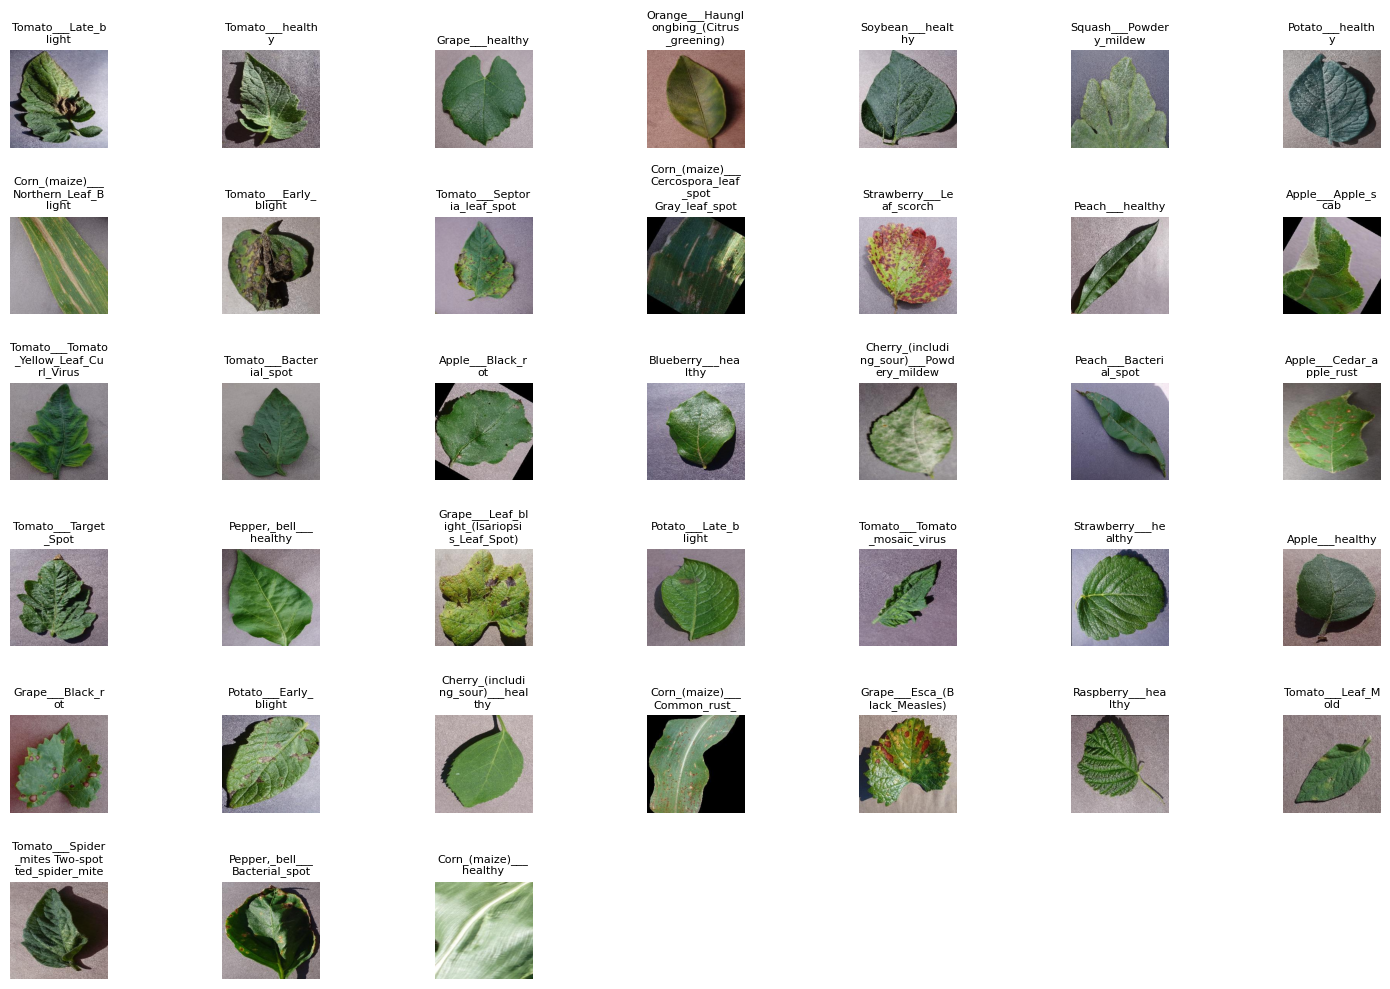

In [7]:
plt.figure(figsize=(15, 10))
shown_classes = set()

for i in range(len(train_df)):
    img_path = train_df['filepaths'].iloc[i]
    label = train_df['labels'].iloc[i]

    if label in shown_classes:
        continue

    shown_classes.add(label)
    img = plt.imread(img_path)

    plt.subplot(6, 7, len(shown_classes))
    plt.imshow(img)

    # Wrap long labels to avoid overlap
    wrapped_label = "\n".join(textwrap.wrap(label, width=15))
    plt.title(wrapped_label, fontsize=8)

    plt.axis('off')

    if len(shown_classes) == 38:
        break

plt.tight_layout()
plt.show()


In [8]:
image=cv2.imread(train_df['filepaths'][1])
image.shape

(256, 256, 3)

# Preprocessing 

In [9]:
# valid and test dataframe
valid_df, test_df = train_test_split(valid_df,  train_size= 0.5, shuffle= True, random_state= 42, stratify=valid_df['labels'])

In [10]:
gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                    target_size=(299, 299), color_mode='rgb', class_mode='categorical',
                                    batch_size=32)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                    target_size=(299, 299), color_mode='rgb', class_mode='categorical',
                                    batch_size=32)

test_gen = gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                   target_size=(299, 299), color_mode='rgb', class_mode='categorical',
                                   batch_size=32, shuffle=False)


Found 70295 validated image filenames belonging to 38 classes.
Found 8786 validated image filenames belonging to 38 classes.
Found 8786 validated image filenames belonging to 38 classes.


In [11]:
print(train_gen.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

# Model

In [14]:
base_model = keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
)
model=Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256,activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(38,activation='softmax')
])
model.compile(optimizer=Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 8, 8, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_409              │ (None, 8, 8, 1536)          │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_410              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_411              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 38)                  │           2,470 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,781,510 (208.97 MB)

 Trainable params: 54,717,126 (208.73 MB)

 Non-trainable params: 64,384 (251.50 KB)

In [15]:
hist=model.fit(train_gen,validation_data= valid_gen,epochs=4,batch_size=32)

Epoch 1/4


I0000 00:00:1751249220.462055      97 service.cc:148] XLA service 0x7ed0e4003830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751249220.462757      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751249231.872425      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751249283.284014      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1495s 596ms/step - accuracy: 0.6360 - loss: 1.4725 - val_accuracy: 0.9651 - val_loss: 0.3998
Epoch 2/4
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1200s 546ms/step - accuracy: 0.9591 - loss: 0.1952 - val_accuracy: 0.9876 - val_loss: 0.0595
Epoch 3/4
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1200s 546ms/step - accuracy: 0.9775 - loss: 0.1045 - val_accuracy: 0.9851 - val_loss: 0.0750
Epoch 4/4
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1198s 545ms/step - accuracy: 0.9829 - loss: 0.0760 - val_accuracy: 0.9948 - val_loss: 0.0217


# Evaluation

In [16]:
model.evaluate(train_gen)

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 344s 157ms/step - accuracy: 0.9978 - loss: 0.0082


[0.00814148597419262, 0.9978234767913818]

In [17]:
model.evaluate(valid_gen)

275/275 ━━━━━━━━━━━━━━━━━━━━ 42s 154ms/step - accuracy: 0.9940 - loss: 0.0260


[0.021728582680225372, 0.9947643876075745]

In [18]:
model.evaluate(test_gen)

275/275 ━━━━━━━━━━━━━━━━━━━━ 81s 295ms/step - accuracy: 0.9949 - loss: 0.0198


[0.022730236873030663, 0.9951058626174927]

In [19]:
hist=pd.DataFrame(hist.history)

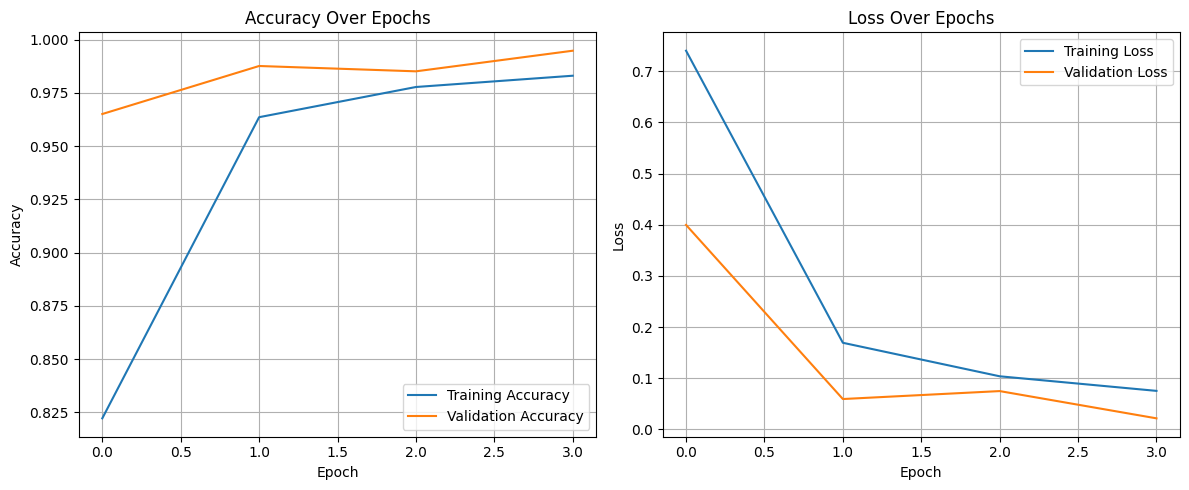

In [20]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

275/275 ━━━━━━━━━━━━━━━━━━━━ 69s 205ms/step


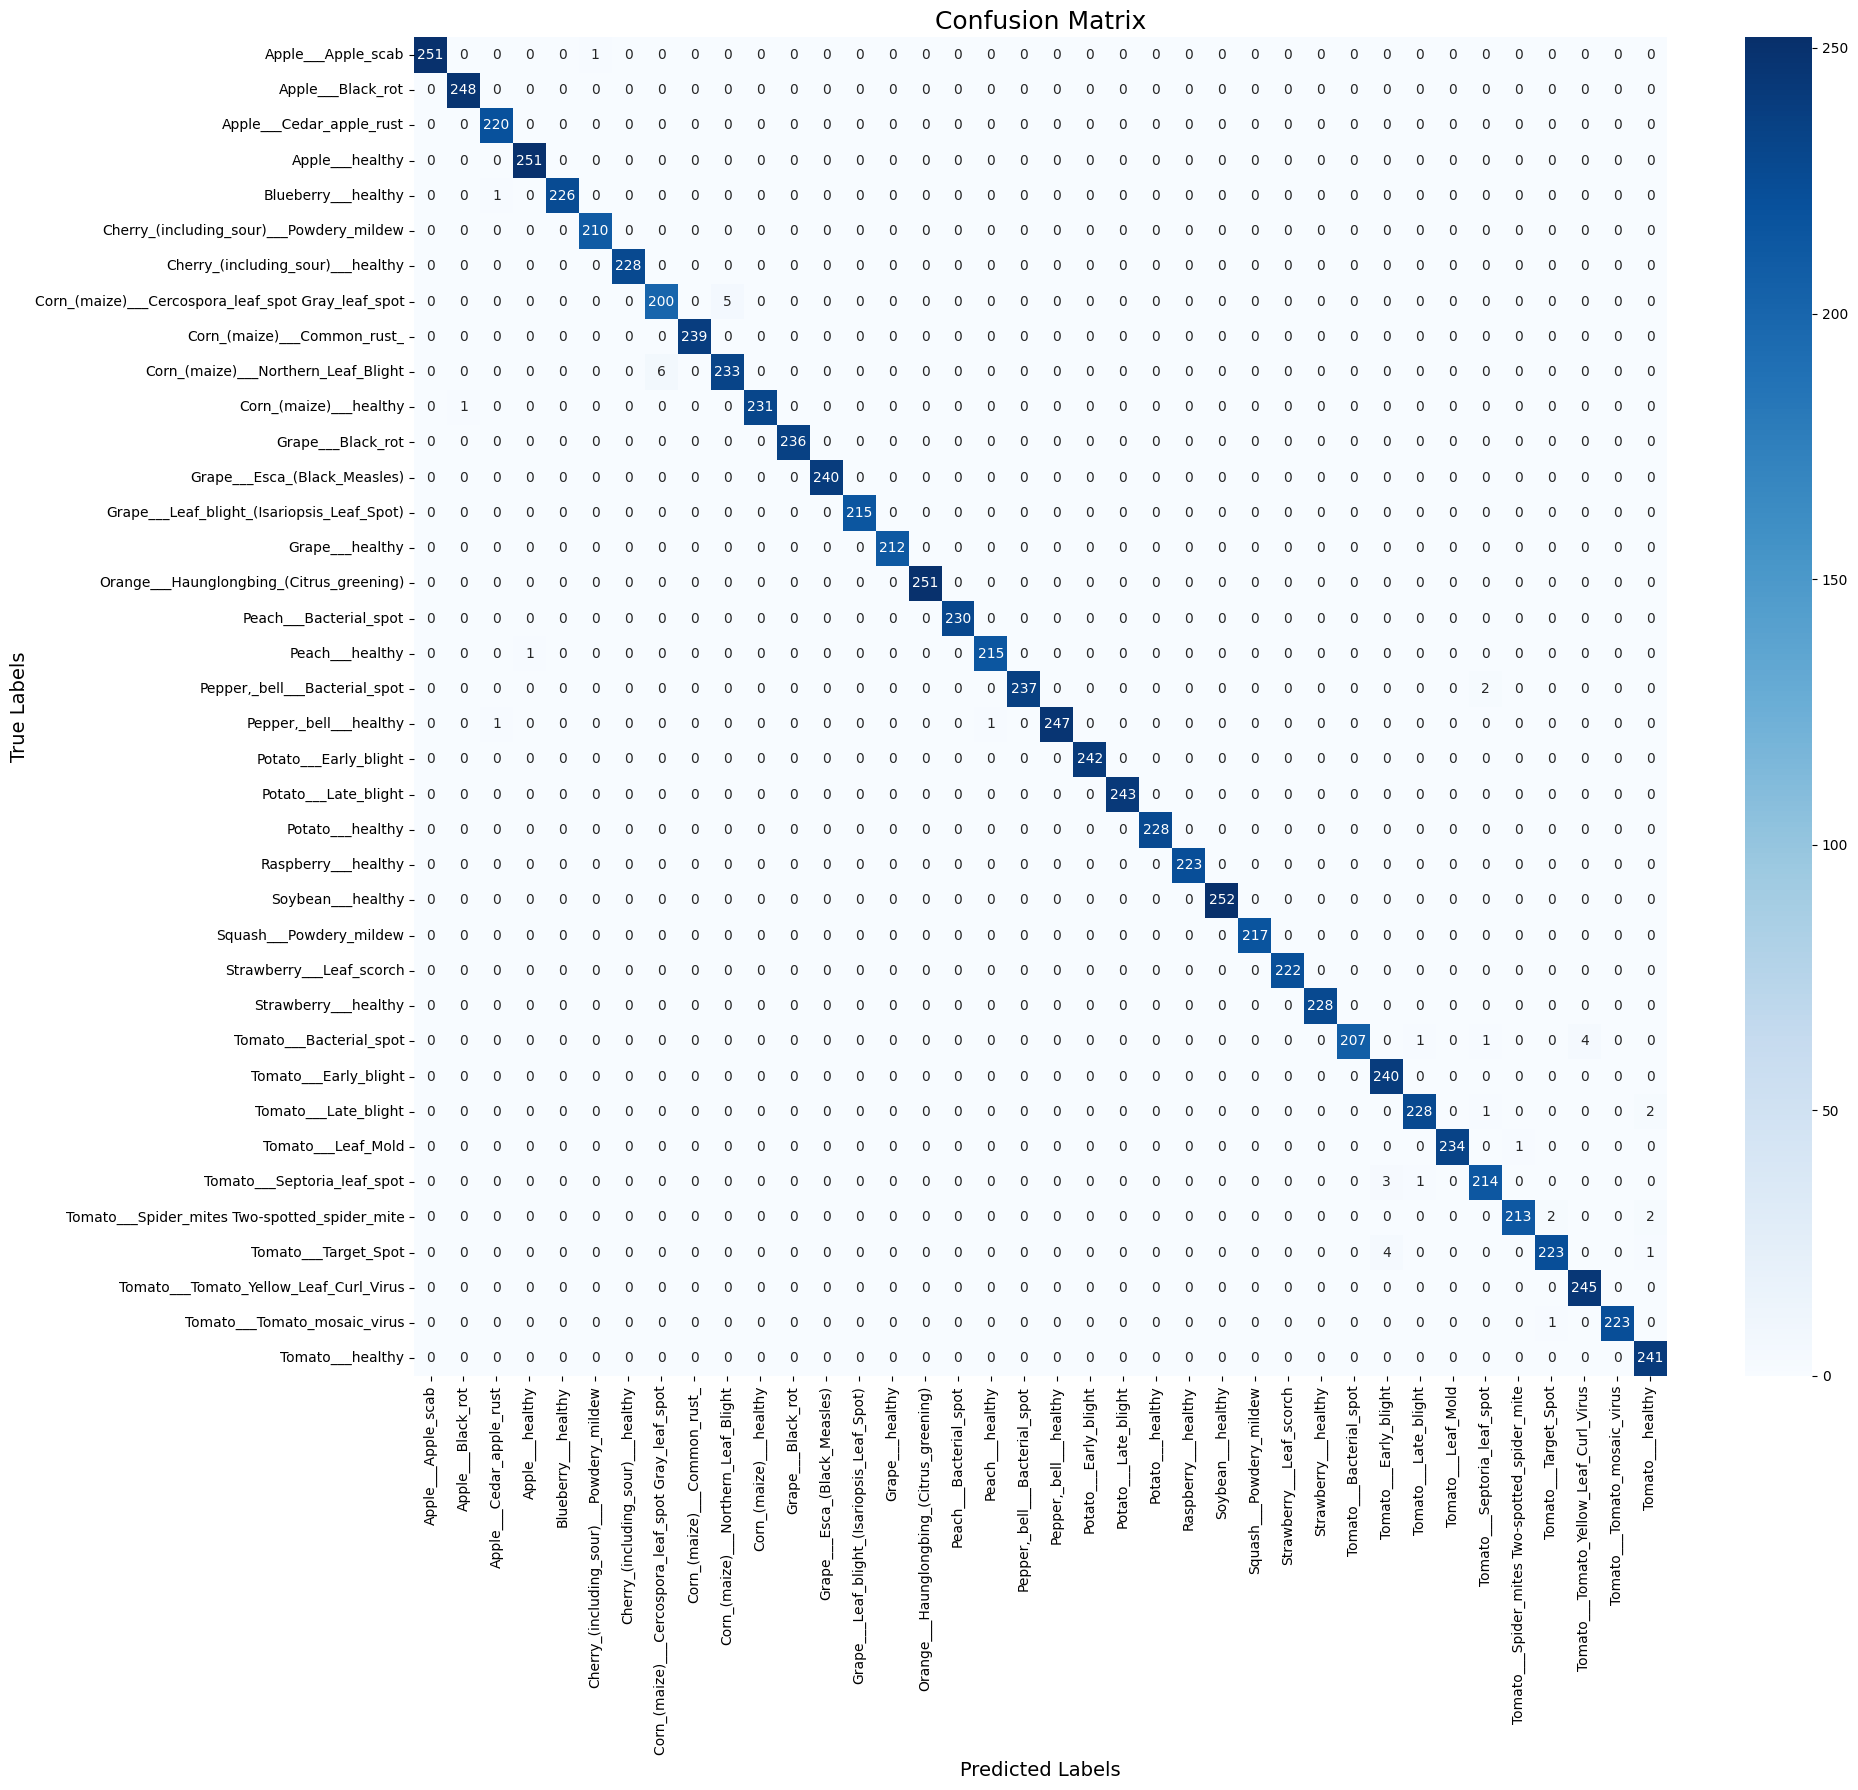

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       252
                                 Apple___Black_rot       1.00      1.00      1.00       248
                          Apple___Cedar_apple_rust       0.99      1.00      1.00       220
                                   Apple___healthy       1.00      1.00      1.00       251
                               Blueberry___healthy       1.00      1.00      1.00       227
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       210
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       228
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.98      0.97       205
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       239
               Corn_(maize)___Northern_Leaf_Blight       0.98      0.97      0.

In [21]:

true_labels = test_gen.classes
class_names = list(test_gen.class_indices.keys())


pred_probs = model.predict(test_gen)
pred_labels = np.argmax(pred_probs, axis=1)


cm = confusion_matrix(true_labels, pred_labels)


plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix", fontsize=18)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


report = classification_report(true_labels, pred_labels, target_names=class_names)
print(report)


# Test Model In Real Data

275/275 ━━━━━━━━━━━━━━━━━━━━ 42s 151ms/step


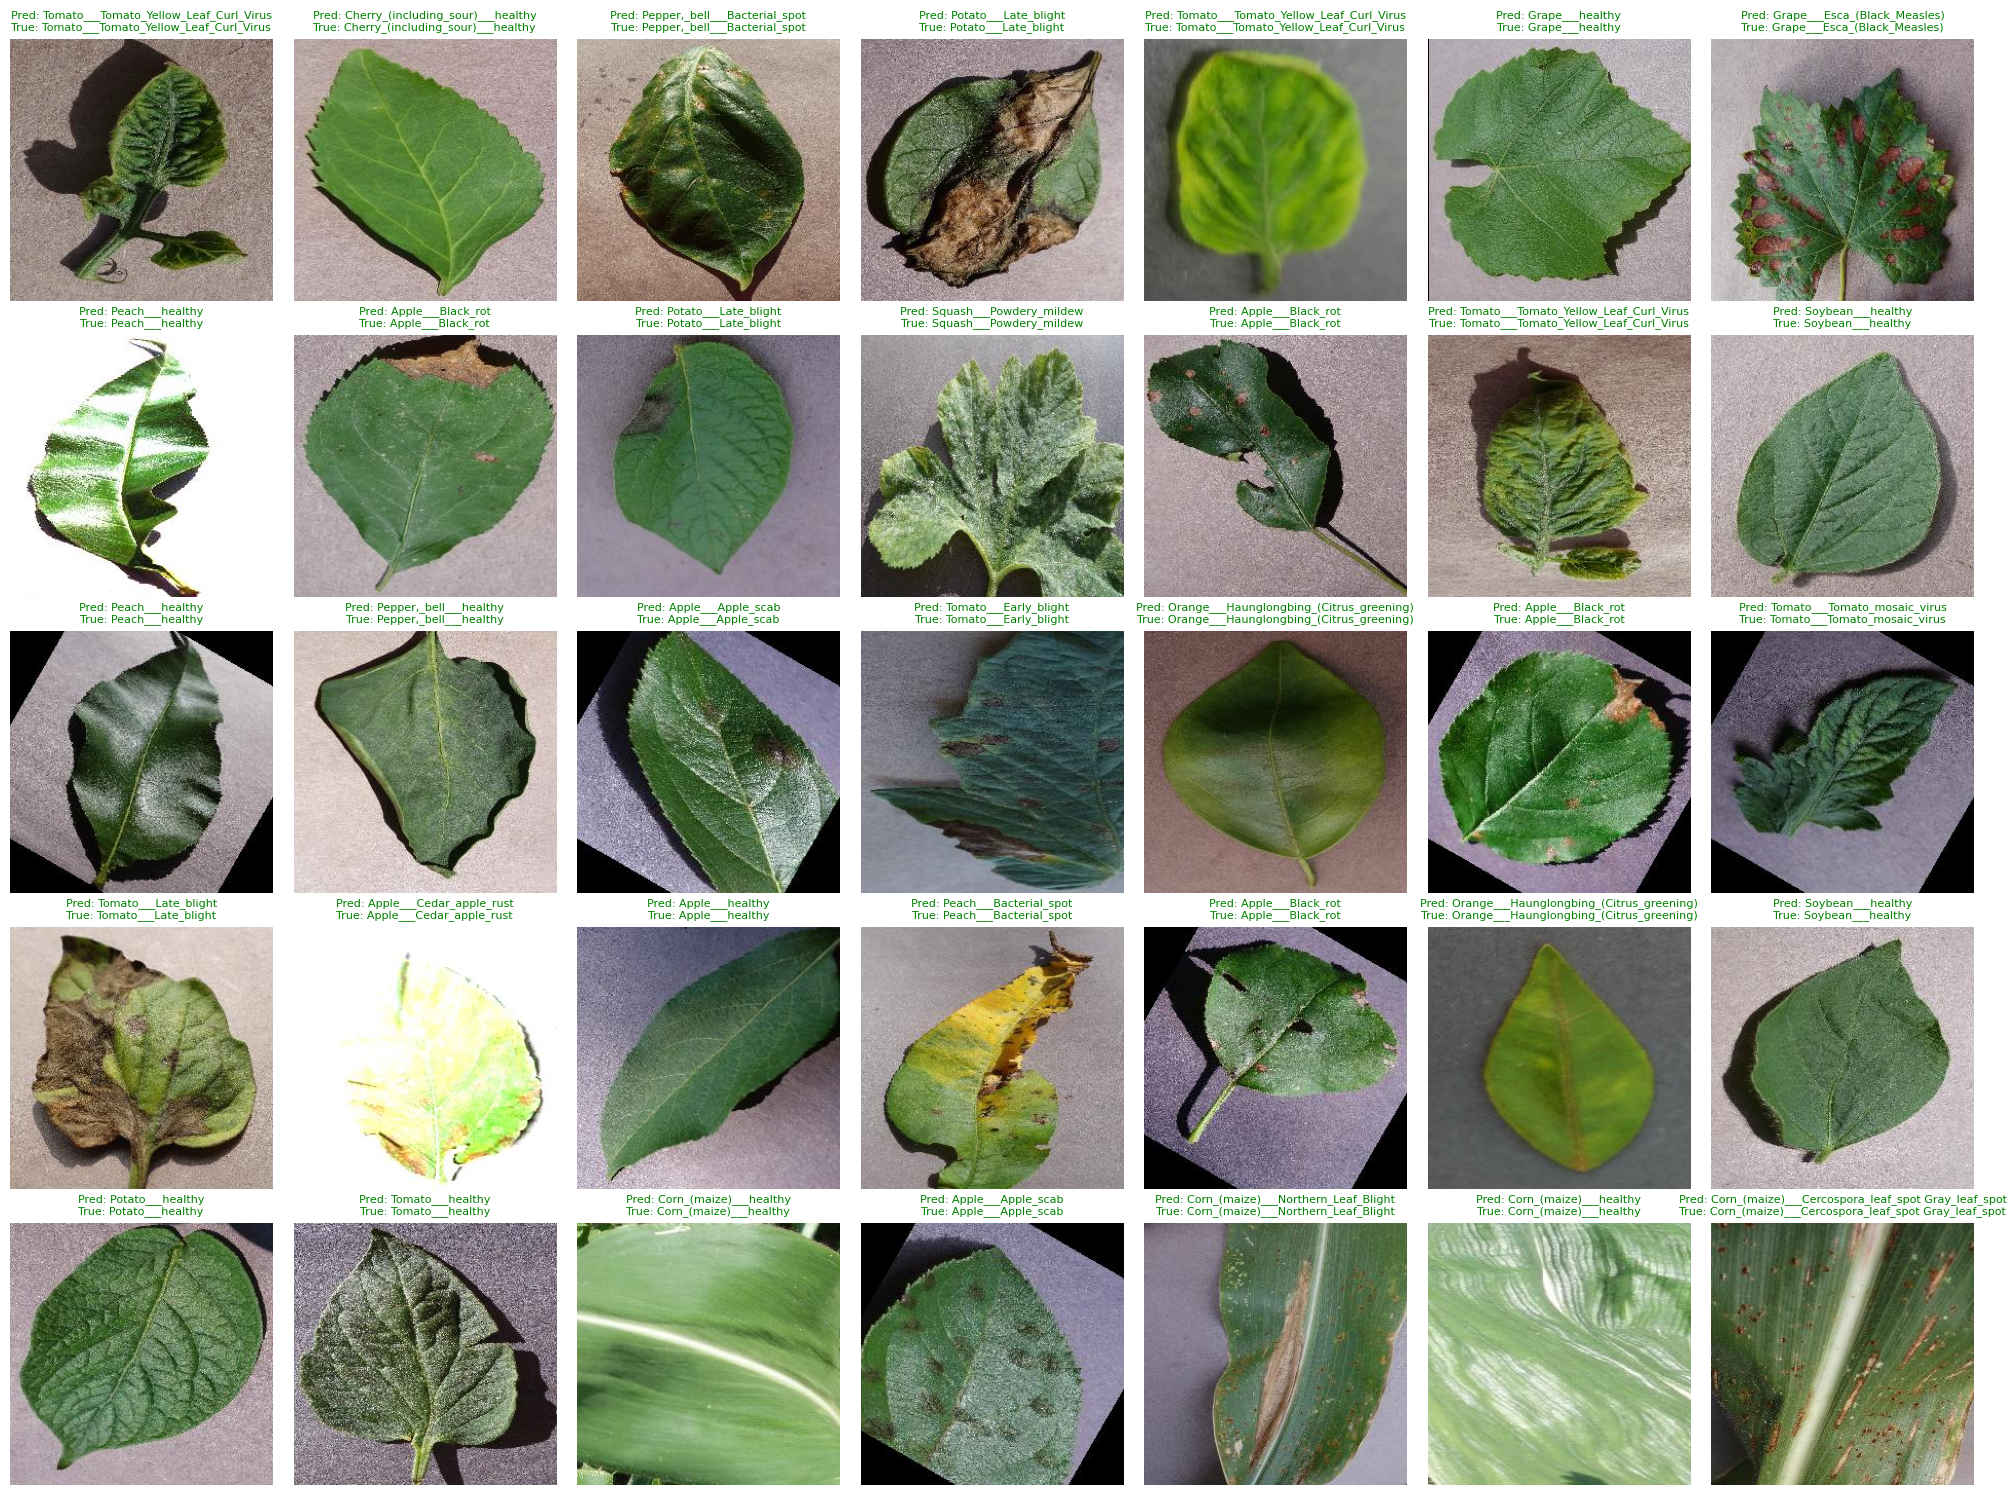

In [22]:
pred_probs = model.predict(test_gen)
pred_indices = np.argmax(pred_probs, axis=1)
true_indices = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

image_paths = test_gen.filepaths


num_images = 35  
indices = random.sample(range(len(image_paths)), num_images)


plt.figure(figsize=(20, 15))

for i, idx in enumerate(indices):
    img = plt.imread(image_paths[idx])
    true_label = class_labels[true_indices[idx]]
    pred_label = class_labels[pred_indices[idx]]

    plt.subplot(5, 7, i+1)
    plt.imshow(img)
    plt.axis('off')

    # Show predicted vs actual
    color = 'green' if pred_label == true_label else 'red'
    title = f"Pred: {pred_label}\nTrue: {true_label}"
    plt.title(title, fontsize=8, color=color)

plt.tight_layout()
plt.show()


# Save Model

In [23]:
model.save('Pretrained_model.h5')